In [1]:
import MDAnalysis
import numpy as np
from collections import Counter
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm

In [2]:
def plot_density_distr(h_ave_list, b_list, title):
	data1 = h_ave_list[0]
	data1= list(np.array(data1).flatten())
	data2 = h_ave_list[1]
	data2= list(np.array(data2).flatten())
	data3 = h_ave_list[2]
	data3= list(np.array(data3).flatten())
	
	plt.figure(figsize=(3, 2))
	sns.kdeplot(data1, fill=False, color='black', alpha=0.3, linewidth=2, label=f'{b_list[0]} Å') 
	sns.kdeplot(data2, fill=False, color='red', alpha=1, linewidth=2, label=f'{b_list[1]} Å') 
	sns.kdeplot(data3, fill=False, color='blue', alpha=0.3, linewidth=2, label=f'{b_list[2]} Å')  

	plt.tick_params(direction = 'in')

	plt.xlabel(title, fontsize=12)
	plt.ylabel('Probability density', fontsize=12)
	plt.legend(fontsize=10, frameon=False)


	plt.savefig(
	'/home/yzdai/Desktop/atom_density/plot_files/out/'+sys+'-'+title+'.png',        # 文件名
	dpi=350,            
	format='png',      
	bbox_inches='tight', 
	pad_inches=0.0,     
	# facecolor='white', 
	# edgecolor='black', 
	transparent=True, 
	)
def simulate_PBC(points_leaflet, box, r=0.3, edge=None):
	PBC_points = []

	if edge is not None:
		x_min, x_max = edge[0][0], edge[0][-1]
		y_min, y_max = edge[1][0], edge[1][-1]
	else:
		x_min = 0
		x_max = (1 + r) * box[0]
		y_min = 0
		y_max = (1 + r) * box[1]
	for x, y, z in points_leaflet:

		if x_min < x < x_max and y_min < y < y_max:
			PBC_points.append([x, y, z])

		shifts = []
		if x > (1 - r) * box[0]: shifts.append([-box[0], 0])
		if x < r * box[0]:        shifts.append([ box[0], 0])
		if y > (1 - r) * box[1]: shifts.append([0, -box[1]])
		if y < r * box[1]:        shifts.append([0,  box[1]])

		if x > (1 - r) * box[0] and y < r * box[1]:
			shifts.append([-box[0], box[1]])
		if x > (1 - r) * box[0] and y > (1 - r) * box[1]:
			shifts.append([-box[0], -box[1]])
		if x < r * box[0] and y < r * box[1]:
			shifts.append([ box[0], box[1]])
		if x < r * box[0] and y > (1 - r) * box[1]:
			shifts.append([ box[0], -box[1]])
		# 平移后坐标加入
		for dx, dy in shifts:
			new_x, new_y = x + dx, y + dy
			if x_min < new_x < x_max and y_min < new_y < y_max:
				PBC_points.append([new_x, new_y, z])
	return np.array(PBC_points)
def get_h(u, sel, diffnp, edge, box_fr, bin_width):
	# Get the coordinates of the selected atoms
	sel_atoms_obj = u.select_atoms(sel)
	sel_atoms = sel_atoms_obj.positions
	# Move the com of system to the center of present box
	sel_atoms_com = np.add(sel_atoms, diffnp)
	# Rescale the coordinates between 0 - present boxsize
	sel_atoms_pbc = np.mod(sel_atoms_com, box_fr)
	# Generate some fake points to simulate PBC to fill the max box
	PBC_points = simulate_PBC(sel_atoms_pbc, box_fr, r=0.3, edge = edge) 
	# Get the number of atoms within each grid
	# h, _ = np.histogramdd(sel_atoms_pbc, bins=edge, normed = False)
	h, _ = np.histogramdd(PBC_points, bins=edge, normed = False)

	assert np.all(h >= 0), "Histogram contains negative counts!"
	# Convert histogram to densities 
	# x_edges, y_edges, z_edges = edge
	# dx = np.diff(x_edges) 
	# dy = np.diff(y_edges) 
	# dz = np.diff(z_edges) 
	# dx_mesh, dy_mesh, dz_mesh = np.meshgrid(dx, dy, dz, indexing='ij')
	# volumes = dx_mesh * dy_mesh * dz_mesh 
	# dens3d = h / volumes

	volume = bin_width*bin_width*0.5
	dens3d = h / volume

	# Collapse along the z-axis
	# top 1/2 mean
	xy = dens3d.shape[0] * dens3d.shape[1]
	z = dens3d.shape[2]
	reshaped = dens3d.reshape(xy, z)
	mean_vals = np.zeros(xy)
	for i in range(xy):
		row = reshaped[i]
		nonzero = row[row > 0]
		if len(nonzero) > 0:
			sorted_vals = np.sort(nonzero)
			num_keep = max(1, len(sorted_vals) // 2)
			mean_vals[i] = np.mean(sorted_vals[-num_keep:])
	dens2d_mean = mean_vals.reshape(dens3d.shape[0], dens3d.shape[1])

	# # 策略： top 1/2 mean
	# dens2d_mean = np.zeros(shape = (dens3d.shape[0], dens3d.shape[1]))

	# for i in range(0, dens3d.shape[0]):
	#     for j in range(0, dens3d.shape[1]):
	#         all_z = dens3d[i, j, :]
	#         nonzero = all_z[all_z>0]
	#         if len(nonzero) > 0:
	#             sorted_z = sorted(nonzero, reverse=True)
	#             top_n = max(1, len(sorted_z) // 2)
	#             top_z = sorted_z[:top_n]
	#             dens2d_mean[i,j] = np.array(top_z).mean()
	# sum
	dens2d_sum = dens3d.sum(axis=2)
	return dens2d_sum, dens2d_mean
def process_block_wrapper_with_index(args):
	start_block = args[2]
	result = process_block(*args)
	return start_block, result
def process_frame(pdb, trj, frame_index, sel_atom_upper, sel_atom_lower, sel_primary_lipid_upper, sel_primary_lipid_lower, edge, cal_ratio, bin_width):

	u = MDAnalysis.Universe(pdb, trj)
	ts = u.trajectory[frame_index]
	box_fr = ts.dimensions[:3]
	sel_all_com = u.select_atoms('all').center_of_mass()
	diffx = box_fr[0] / 2 - sel_all_com[0]
	diffy = box_fr[1] / 2 - sel_all_com[1]
	diffz = box_fr[2] / 2 - sel_all_com[2]
	diffnp = np.array([diffx, diffy, diffz])

	atom_up_sum, atom_up_mean = get_h(u, 
		sel_atom_upper, diffnp, edge, box_fr, bin_width)
	atom_low_sum, atom_low_mean = get_h(u, 
		sel_atom_lower, diffnp, edge, box_fr, bin_width)

	primary_lipid_up_sum, primary_lipid_up_mean = None, None
	primary_lipid_low_sum, primary_lipid_low_mean = None, None
	if cal_ratio:
		primary_lipid_up_sum, primary_lipid_up_mean = get_h(u, 
			sel_primary_lipid_upper, diffnp, edge, box_fr, bin_width)
		primary_lipid_low_sum, primary_lipid_low_mean = get_h(u, 
			sel_primary_lipid_lower, diffnp, edge, box_fr, bin_width)

	return atom_up_sum, atom_up_mean, atom_low_sum, atom_low_mean, \
		   primary_lipid_up_sum, primary_lipid_low_sum

def process_block(pdb, trj, start_block, end_block, lip_leaflet_raw, primary_lipid_id, edge, cal_ratio, bin_width):
	h_atom_up_mean_all = []
	h_atom_low_mean_all = []
	h_atom_up_sum_all = []
	h_atom_low_sum_all = []
	h_primary_lipid_up_sum_all = []
	h_primary_lipid_low_sum_all = []
	block_progress = tqdm(range(start_block, end_block, n_gap), desc="Processing Blocks", leave=True, position=0)
	for b in block_progress:
		e = min(b + n_gap, end_block)  
		fr5_leaflets = lip_leaflet_raw[b:e, :]
		most_common_leaflet_tag = [Counter(column).most_common(1)[0][0] for column in zip(*fr5_leaflets)]
		upper_resid_list = [str(index+1) for index, value in enumerate(most_common_leaflet_tag) if value == 0]
		lower_resid_list = [str(index+1) for index, value in enumerate(most_common_leaflet_tag) if value == 1]
		sel_atom_upper = 'resid ' + ' '.join(upper_resid_list)
		sel_atom_lower = 'resid ' + ' '.join(lower_resid_list)
		upper_primary_lipid_list = [str(x) for x in sorted(list(set([int(idx) for idx in primary_lipid_id]) & set([int(idx) for idx in upper_resid_list])))]
		lower_primary_lipid_list = [str(x) for x in sorted(list(set([int(idx) for idx in primary_lipid_id]) & set([int(idx) for idx in lower_resid_list])))]
		sel_primary_lipid_upper = 'resid ' + ' '.join([str(x) for x in upper_primary_lipid_list])
		# print(sel_primary_lipid_upper)
		sel_primary_lipid_lower = 'resid ' + ' '.join([str(x) for x in lower_primary_lipid_list])
		# if(b == 9500):
		#     print(sel_atom_upper)
		#     print(sel_primary_lipid_upper)

		frame_indices = list(range(b, e))
		frame_progress = tqdm(frame_indices, desc=f"Frames {b}-{e}", leave=False, position=1)

		results = [
			process_frame(pdb, trj, frame, sel_atom_upper, sel_atom_lower,
						  sel_primary_lipid_upper, sel_primary_lipid_lower, edge, cal_ratio, bin_width)
			for frame in frame_progress
		]

		h_atom_up_mean = np.mean([r[1] for r in results], axis=0)
		h_atom_low_mean = np.mean([r[3] for r in results], axis=0)
		h_atom_up_mean_all.append(h_atom_up_mean)
		h_atom_low_mean_all.append(h_atom_low_mean)
		if cal_ratio:
			h_atom_up_sum = np.mean([r[0] for r in results], axis=0)
			h_atom_low_sum = np.mean([r[2] for r in results], axis=0)
			h_primary_lipid_up_sum = np.mean([r[4] for r in results], axis=0)
			h_primary_lipid_low_sum = np.mean([r[5] for r in results], axis=0)
			h_atom_up_sum_all.append(h_atom_up_sum)
			h_atom_low_sum_all.append(h_atom_low_sum)
			h_primary_lipid_up_sum_all.append(h_primary_lipid_up_sum)
			h_primary_lipid_low_sum_all.append(h_primary_lipid_low_sum)
	return h_atom_up_mean_all, h_atom_low_mean_all, \
		   h_atom_up_sum_all, h_atom_low_sum_all, h_primary_lipid_up_sum_all, h_primary_lipid_low_sum_all


In [3]:
cal_ratio = False
n_gap = 5

# sys = 'dpdo280k'
# trj = "/data/gulab/yzdai/dyz_project1/data/dppc_dopc_280k/traj-dpdo280k-0-10us-pbc.xtc"
# pdb = "/data/gulab/yzdai/dyz_project1/data/dppc_dopc_280k/dppc_dopc_280k_0us.gro"
# fn_leaflet = '/data/gulab/yzdai/data4/phase_identification/leaflet/dpdo280k-leaflet.xvg'
# b = 9995
# e = 10000
# primary_lipid_id = list(range(1, 347)) + list(range(577, 923))
# primary_lipid_id = [str(x) for x in primary_lipid_id]

sys='dpdochl280k'
pdb="/data/gulab/yzdai/dyz_project1/data/dppc_dopc_chl_280k/snapshot9.99us.gro"
trj="/data/gulab/yzdai/dyz_project1/data/dppc_dopc_chl_280k/dpdochl280k-8us-pbc.xtc"
fn_leaflet='/data/gulab/yzdai/data4/phase_identification/leaflet/dpdochl280k-leaflet.xvg'
b = 7995
e = 8000
primary_lipid_id = list(range(1, 203)) + list(range(577, 779))
primary_lipid_id = [str(x) for x in primary_lipid_id]

# sys='psmdopochl'
# pdb="/data/gulab/yzdai/dyz_project1/data/psmdopochl/psmdopochl-rho0.8.gro"
# trj="/data/gulab/yzdai/dyz_project1/data/psmdopochl/trjcat-psmdopochl-rho0.8-1ns-1-22.xtc"
# fn_leaflet='/data/gulab/yzdai/data4/phase_identification/leaflet/psmdopochl300k-0.8-0-20us-leaflet.xvg'
# b = 19995
# e = 20000
# primary_lipid_id = list(range(1, 91)) + list(range(91, 181))
# primary_lipid_id = [str(x) for x in primary_lipid_id]

In [6]:

u = MDAnalysis.Universe(pdb, trj)
box_x = box_y = box_z = 0
for ts in u.trajectory[b:e]:
	box = ts.dimensions[:3]
	box_x = max(box_x, box[0])
	box_y = max(box_y, box[1])
	box_z = max(box_z, box[2])
max_box = (box_x, box_y, box_z)
h_atom_list_up = []; h_atom_list_low = []
r_list_up = []; r_list_low = []
e_list = []
bin_width_list = [2,3,4]
lip_leaflet_raw = np.loadtxt(fn_leaflet)[:, 1:]
for bin_width in bin_width_list:
	x_bins = int(np.ceil(max_box[0] / bin_width))
	y_bins = int(np.ceil(max_box[1] / bin_width))
	z_bins = int(np.ceil(max_box[2] / 0.5))
	x_edges = np.linspace(0, 0 + x_bins * bin_width, x_bins + 1)
	y_edges = np.linspace(0, 0 + y_bins * bin_width, y_bins + 1)
	z_edges = np.linspace(0, 0 + z_bins * 0.5, z_bins + 1)
	edge3d = (x_edges, y_edges, z_edges)

	num_blocks = 1 
	block_size = (e - b) // num_blocks
	blocks = [(b + i * block_size, b + (i + 1) * block_size) for i in range(num_blocks)]
	blocks[-1] = (blocks[-1][0], e)

	with Pool(processes=num_blocks) as pool:
		all_results = list(tqdm(
			pool.imap_unordered(
				process_block_wrapper_with_index,
				[(pdb, trj, start_block, end_block, lip_leaflet_raw, primary_lipid_id, edge3d, cal_ratio, bin_width)
				for start_block, end_block in blocks]
			),
			total=len(blocks),
			desc="Processing Blocks"
		))

	all_results.sort(key=lambda x: x[0])  # 按 start_block 排序

	all_results = [result for _, result in all_results]

	h_atom_up_mean_all = [item for block_result in all_results for item in block_result[0]]
	h_atom_low_mean_all = [item for block_result in all_results for item in block_result[1]]

	if cal_ratio:
		h_atom_up_sum_all = [item for block_result in all_results for item in block_result[2]]
		h_atom_low_sum_all = [item for block_result in all_results for item in block_result[3]]
		h_primary_lipid_up_sum_all = [item for block_result in all_results for item in block_result[4]]
		h_primary_lipid_low_sum_all = [item for block_result in all_results for item in block_result[5]]
	# h_atom_list_up.append(np.array(h_atom_up_mean_all)/0.3492629423089485)
	# h_atom_list_low.append(np.array(h_atom_low_mean_all)/0.3492629423089485)
	h_atom_list_up.append(h_atom_up_mean_all/(np.mean(h_atom_up_mean_all)/2+np.mean(h_atom_low_mean_all)/2))
	h_atom_list_low.append(h_atom_low_mean_all/(np.mean(h_atom_up_mean_all)/2+np.mean(h_atom_low_mean_all)/2))
	r_list_up.append(np.array(h_primary_lipid_up_sum_all)/np.array(h_atom_up_sum_all))
	r_list_low.append(np.array(h_primary_lipid_low_sum_all)/np.array(h_atom_low_sum_all))
	e_list.append(edge3d)
print('End of density calculation')

Processing Blocks: 100%|██████████| 1/1 [00:37<00:00, 37.86s/it]

End of density calculation


# Plotting

(90, 90)
(60, 60)
(45, 45)
(60, 60)


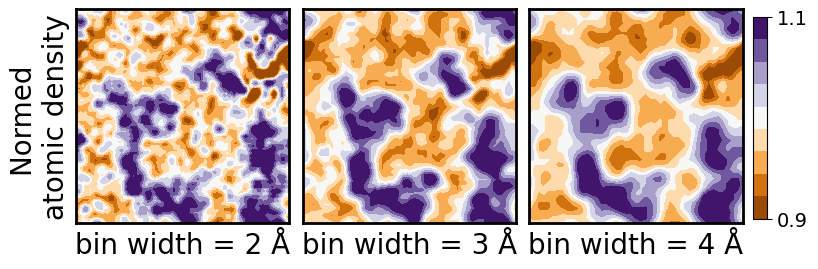

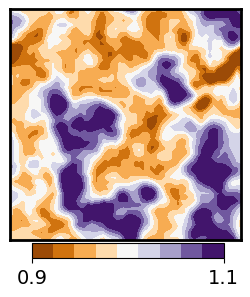

In [98]:
from scipy.ndimage import uniform_filter
import matplotlib
from copy import deepcopy
from matplotlib.ticker import LinearLocator
def plotDensmap(data, edge):
	normData = deepcopy(data)
	print(normData.shape)
	
	normData = np.where (normData <1.1, normData, 1.1)           #dpdo + dpdochl
	normData = np.where (normData >0.9, normData, 0.9)
	levels = LinearLocator(numticks=10).tick_values(0.9, 1.1)

	# normData = np.where (normData <1.05, normData, 1.05)         #psmdopochl
	# normData = np.where (normData >0.95, normData, 0.95)
	# levels = LinearLocator(numticks=10).tick_values(0.95, 1.05)

	cmap = plt.get_cmap('PuOr')
	xMatrix = np.zeros((normData.shape[0], normData.shape[1]))
	yMatrix = np.zeros((normData.shape[0], normData.shape[1]))
	
	xaxis = edge[0][1:]
	yaxis = edge[1][1:]
	for i in range(0, normData.shape[0]):
		xMatrix[i, :] = xaxis
	for j in range(0, normData.shape[1]):
		yMatrix[:, j] = yaxis
	im = plt.contourf(yMatrix,
			 xMatrix, normData, levels=levels,
			 cmap=cmap)
	# im = plt.pcolormesh(yMatrix, xMatrix, normData, cmap=cmap)#, shading='auto', edgecolors='w', linewidth=0.5
	densmap = plt.gca()
	densmap.set_aspect(1)
	#set border width
	densmap.spines['bottom'].set_linewidth(2)
	densmap.spines['left'].set_linewidth(2)
	densmap.spines['top'].set_linewidth(2)
	densmap.spines['right'].set_linewidth(2)
	densmap.tick_params(axis='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
	return im

def spatial_smooth(matrix, n_iter=2, n_size =3):
	new_matrix = deepcopy(matrix)
	for i in range(n_iter):
		new_matrix = np.around(uniform_filter(new_matrix, size = n_size, mode='wrap'), decimals=2)
	return new_matrix
def plot_density_bin(atom_up_filtered, b_list, e_list, title_str):#

	fig1 = plt.figure(figsize=(9.5, 3.2))#
	gs = matplotlib.gridspec.GridSpec(2, 4, width_ratios=[0.25, 1, 1, 1,], height_ratios=[1,0.1], wspace=0.01, hspace=0.1)

	for i, title in enumerate(['Normed \natomic density']):
		ax = fig1.add_subplot(gs[i, 0]) 
		ax.axis('off')  
		ax.text(0.5, 0.5, title, ha='center', va='center', rotation=90, transform=ax.transAxes, fontsize = 20)

	for i, title in enumerate(['bin width = 2 Å', 'bin width = 3 Å', 'bin width = 4 Å']):
		ax = fig1.add_subplot(gs[1, i+1]) 
		ax.axis('off') 
		ax.text(0.5, 0.5, title, ha='center', va='center', transform=ax.transAxes, fontsize = 20) 

	for i in range(len(b_list)):
		ax = plt.subplot(gs[0, i % 3 + 1])
		im = plotDensmap(atom_up_filtered[i], e_list[i])    

	cbar_ax = fig1.add_axes([0.905, 0.226, 0.015, 0.63])  # [left, bottom, width, height]
	cbar = fig1.colorbar(im, cax=cbar_ax)

	cbar.set_ticks([0.9, 1.1])          #dpdo + dpdochl
	cbar.set_ticklabels(['0.9', '1.1'])

	# cbar.set_ticks([0.95, 1.05])          #psmdopochl
	# cbar.set_ticklabels(['0.95', '1.05'])

	cbar.ax.tick_params(labelsize=14)

	# plt.suptitle(title_str,fontsize = 25)
	# plt.subplots_adjust(top=0.9)

	# plt.show()
	plt.savefig(
	'/data/gulab/yzdai/data4/phase_identification/plot/output/bin_choice/'+sys+'-bin.png',        # 文件名
	dpi=350,             
	format='png',      
	bbox_inches='tight',
	pad_inches=0.0,     
	# facecolor='white',  
	# edgecolor='black',  
	transparent=True,   
	)
h_atom_list_after_filter = deepcopy(h_atom_list_up)
# r_list_after_filter = deepcopy(r_list_up)
for i in range(len(h_atom_list_up)):
	h_atom_list_after_filter[i] = spatial_smooth(h_atom_list_up[i].squeeze())
	# r_list_after_filter[i] = spatial_smooth(r_list_up[i].squeeze())
plot_density_bin(h_atom_list_after_filter, bin_width_list, e_list, title_str = 'Density map ('+sys+')')#
# plt.close()

fig1 = plt.figure(figsize=(3, 3))#
im = plotDensmap(h_atom_list_after_filter[1], e_list[1])   

cbar_ax = fig1.add_axes([0.20, 0.05, 0.64, 0.05]) 
cbar = fig1.colorbar(im, cax=cbar_ax, orientation='horizontal')

cbar.set_ticks([0.9, 1.1])          #dpdo + dpdochl
cbar.set_ticklabels(['0.9', '1.1'])

# cbar.set_ticks([0.95, 1.05])          #psmdopochl
# cbar.set_ticklabels(['0.95', '1.05'])
cbar.ax.tick_params(labelsize=14, direction='out')

plt.savefig(
'/data/gulab/yzdai/data4/phase_identification/plot/output/bin_choice/'+sys+'-bin3.png',        # 文件名
dpi=350,            
format='png',       
bbox_inches='tight',
pad_inches=0.0,     
# facecolor='white',  
# edgecolor='black',   
transparent=True,  
)

# plot distribution

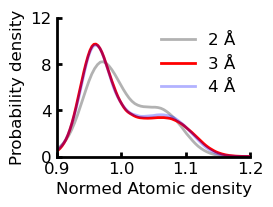

In [25]:
# sys = 'psmdopochl'
sys = 'dpdo280k'
# sys = 'dpdochl280k'
def plot_density_distr(h_ave_list, b_list, title):
	data1 = h_ave_list[0]
	data1= list(np.array(data1).flatten())
	data2 = h_ave_list[1]
	data2= list(np.array(data2).flatten())
	data3 = h_ave_list[2]
	data3= list(np.array(data3).flatten())
	
	plt.figure(figsize=(2.5, 1.8))
	sns.kdeplot(data1, fill=False, color='black', alpha=0.3, linewidth=2, label=f'{b_list[0]} Å')  
	sns.kdeplot(data2, fill=False, color='red', alpha=1, linewidth=2, label=f'{b_list[1]} Å') 
	sns.kdeplot(data3, fill=False, color='blue', alpha=0.3, linewidth=2, label=f'{b_list[2]} Å')

	# plt.xlim(0.90, 1.1)
	# plt.xticks(np.arange(0.90, 1.11, 0.1), fontsize=12)
	# plt.ylim(0, 16)                               #psm
	# plt.yticks(np.arange(0, 17, 4), fontsize=12)

	plt.xlim(0.9, 1.2)
	plt.xticks(np.arange(0.9, 1.21, 0.1), fontsize=12)
	plt.ylim(0, 12)                               #dpdochl + dpdo
	plt.yticks(np.arange(0, 13, 4), fontsize=12)

	plt.tick_params(direction='in', width=2)

	# plt.title(title)
	plt.xlabel(title, fontsize=12)
	plt.ylabel('Probability density', fontsize=12)
	plt.legend(fontsize=12, frameon=False)
	ax = plt.gca()
	ax.spines['top'].set_visible(False)
	ax.spines['right'].set_visible(False) 
	
	ax.spines['left'].set_linewidth(2)
	ax.spines['bottom'].set_linewidth(2)
	# plt.show()
	plt.savefig(
	'/data/gulab/yzdai/data4/phase_identification/plot/output/bin_choice/'+sys+'-'+title+'.png',        # 文件名
	dpi=350,           
	format='png',       
	bbox_inches='tight',
	pad_inches=0.0,    
	# facecolor='white', 
	# edgecolor='black',
	transparent=True,  
	)

suffix_list = ['_bin2','','_bin4']
file_list = ['/data/gulab/yzdai/data4/phase_identification/plot/input/last1us/'+sys+suffix+'.xvg' for suffix in suffix_list]
h_atom_list = []
for file_path in file_list:
	with open(file_path, 'r') as file:
		normed_density = np.loadtxt(file)
	h_atom_list.append(normed_density)
bin_width_list = [2,3,4]
plot_density_distr(h_atom_list, bin_width_list, title='Normed Atomic density')# ('+sys+')')
# plot_density_distr(r_list_up, bin_width_list, title='Lipid Composition')# ('+sys+')')

(54, 54)


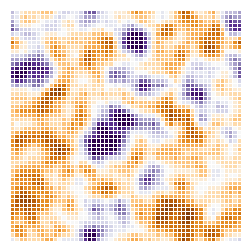

In [19]:
from scipy.ndimage import uniform_filter
import matplotlib
from copy import deepcopy
from matplotlib.ticker import LinearLocator
def spatial_smooth(matrix, n_iter=2, n_size =3):
	new_matrix = deepcopy(matrix)
	for i in range(n_iter):
		new_matrix = np.around(uniform_filter(new_matrix, size = n_size, mode='wrap'), decimals=2)
	return new_matrix
def plotDensmap_edge(data, edge):
	normData = deepcopy(data)
	print(normData.shape)
	
	normData = np.where (normData <1.1, normData, 1.1)           #dpdo + dpdochl
	normData = np.where (normData >0.9, normData, 0.9)
	levels = LinearLocator(numticks=10).tick_values(0.9, 1.1)

	# normData = np.where (normData <1.05, normData, 1.05)         #psmdopochl
	# normData = np.where (normData >0.95, normData, 0.95)
	# levels = LinearLocator(numticks=10).tick_values(0.95, 1.05)

	cmap = plt.get_cmap('PuOr')
	xMatrix = np.zeros((normData.shape[0], normData.shape[1]))
	yMatrix = np.zeros((normData.shape[0], normData.shape[1]))
	
	xaxis = edge[0][1:]
	yaxis = edge[1][1:]
	for i in range(0, normData.shape[0]):
		xMatrix[i, :] = xaxis
	for j in range(0, normData.shape[1]):
		yMatrix[:, j] = yaxis
	im = plt.pcolormesh(yMatrix,
			 xMatrix, normData,
			 cmap=cmap, edgecolors='white', linewidth=0.4)
	# im = plt.pcolormesh(yMatrix, xMatrix, normData, cmap=cmap)#, shading='auto', edgecolors='w', linewidth=0.5
	densmap = plt.gca()
	densmap.set_aspect(1)
	#set border width
	densmap.spines['bottom'].set_linewidth(0)
	densmap.spines['left'].set_linewidth(0)
	densmap.spines['top'].set_linewidth(0)
	densmap.spines['right'].set_linewidth(0)
	densmap.tick_params(axis='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
	return im
h_atom_list_after_filter = deepcopy(h_atom_list_up)
for i in range(len(h_atom_list_up)):
	h_atom_list_after_filter[i] = spatial_smooth(h_atom_list_up[i].squeeze())
fig1 = plt.figure(figsize=(3, 3))#
im = plotDensmap_edge(h_atom_list_after_filter[1], e_list[1])   

# cbar_ax = fig1.add_axes([0.20, 0.05, 0.64, 0.05]) 
# cbar = fig1.colorbar(im, cax=cbar_ax, orientation='horizontal')

# cbar.set_ticks([0.9, 1.1])          #dpdo + dpdochl
# cbar.set_ticklabels(['0.9', '1.1'])

# # cbar.set_ticks([0.95, 1.05])          #psmdopochl
# # cbar.set_ticklabels(['0.95', '1.05'])
# cbar.ax.tick_params(labelsize=14, direction='out')

plt.savefig(
'/data/gulab/yzdai/data4/phase_identification/plot/output/bin_choice/'+sys+'-edge.png',        # 文件名
dpi=350,       
format='png',      
bbox_inches='tight',
pad_inches=0.0,   
# facecolor='white',  
# edgecolor='black',  
transparent=False, 
)